## feature ranking with elimination

In [1]:
from pathlib import Path

In [2]:
import csv
import time  # Just to compare fit times
from pathlib import Path
from pprint import pprint
import csv
import multiprocessing

In [3]:
import numpy as np
# import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
# from tune_sklearn import TuneSearchCV
# from xgboost import XGBRegressor
# import xgboost as xgb


In [8]:
input_dataset_path = Path('../../data/input_dataset_filtered.csv')

In [9]:
%%time

# read the csv file created
train = np.genfromtxt(input_dataset_path, delimiter=',',skip_header=1)


X, y = train[:, 1:], train[:, :1]
y = y.ravel()

# Set training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

CPU times: user 15.4 s, sys: 934 ms, total: 16.4 s
Wall time: 16.3 s


In [10]:
headers = next(csv.reader(open(input_dataset_path)))
pprint(headers)

['target',
 '/g/data/ge3/sheece/LOC_distance_to_coast.tif',
 '/g/data/ge3/sheece/mrvbf_9.tif',
 '/g/data/ge3/sheece/relief_mrvbf_3s_mosaic.tif',
 '/g/data/ge3/sheece/relief_elev_focalrange1000m_3s.tif',
 '/g/data/ge3/sheece/relief_elev_focalrange300m_3s.tif',
 '/g/data/ge3/sheece/saga_wetSM_85_resampled.tif',
 '/g/data/ge3/sheece/tpi_300.tif',
 '/g/data/ge3/sheece/slope_fill2.tif',
 '/g/data/ge3/sheece/dem_fill.tif',
 '/g/data/ge3/sheece/3dem_mag2.tif',
 '/g/data/ge3/sheece/3dem_mag1_fin.tif',
 '/g/data/ge3/sheece/3dem_mag0.fin.tif',
 '/g/data/ge3/sheece/relief_roughness.tif',
 '/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif',
 '/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif',
 '/g/data/ge3/sheece/Dose_2016.tif',
 '/g/data/ge3/sheece/Potassium_2016.tif',
 '/g/data/ge3/sheece/Thorium_2016.tif',
 '/g/data/ge3/sheece/Rad2016U_Th.tif',
 '/g/data/ge3/sheece/Rad2016K_Th.tif',
 '/g/data/ge3/sheece/national_Wii_RF_multirandomforest_prediction.tif',
 '/g/data/ge3/sheece/si_geol1.tif',
 '/g/data/ge3/she

## Build-in Recursive feature elimination with cross-validation


Optimal number of features : 34


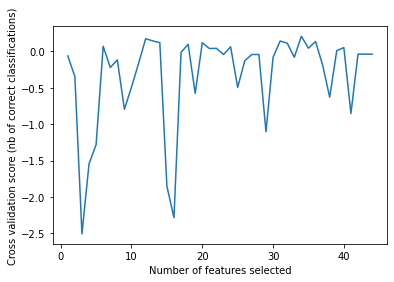

CPU times: user 4h 31min 20s, sys: 22.5 s, total: 4h 31min 42s
Wall time: 23min 34s


In [11]:
%%time

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV


# Create the RFE object and compute a cross-validated score.
xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2)

# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=xgb_model, 
              step=1, 
              cv=2,
              scoring='r2',
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()

In [12]:
rfecv.support_

array([ True,  True,  True,  True, False,  True, False, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True])

In [13]:
rfecv.ranking_

array([ 1,  1,  1,  1,  4,  1,  7,  8,  1,  1,  1,  9,  2,  1, 11,  1,  1,
        1,  1,  1,  6,  1,  1,  1,  1,  1,  1,  1,  1,  5, 10,  1,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  1,  1,  1])

## In-house Recursive feature elimination with cross-validation

In [15]:
import csv
import time 
from pathlib import Path
from pprint import pprint
import csv
import multiprocessing
import pandas as pd
import numpy as np
import distributed

import dask
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, wait, LocalCluster

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
import xgboost as xgb
import statistics


In [60]:
cluster = LocalCluster(n_workers=20,threads_per_worker=2,dashboard_address='0.0.0.0:8787')
client = Client(cluster)
client

In [12]:
features = ['LOC_distance_to_coast','mrvbf_9','relief_mrvbf_3s_mosaic','relief_elev_focalrange1000m_3s','relief_elev_focalrange300m_3s','saga_wetSM_85_resampled','tpi_300','slope_fill2','dem_fill','3dem_mag2','3dem_mag1_fin','3dem_mag0.fin','relief_roughness','LATITUDE_GRID1_clip','Dose_2016','Potassium_2016','Thorium_2016','Rad2016U_Th','Rad2016K_Th','national_Wii_RF_multirandomforest_prediction','si_geol1','ceno_euc_aust1','Grav_lane_clip','be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata','be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata','be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata','be-30y-85m-avg_BLUE+SWIR2','be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata','be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata','be-30y-85m-avg-RED.filled.lzw.nodata','be-30y-85m-avg-GREEN.filled.lzw.nodata','be-l8-all-85m-avg-BLUE.filled.lzw.nodata','be-l8-all-85m-avg-NIR.filled.lzw.nodata','be-30y-85m-avg-SWIR1.filled.lzw.nodata','be-30y-85m-avg-SWIR2.filled.lzw.nodata','s2-dpca-85m','water-85m','clim_EPA_albers','Clim_Prescott_LindaGregory','clim_PTA_albers','clim_WDA_albers','clim_RSM_albers']

In [30]:
import time
from pathlib import Path
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import XGBRegressor
from multiprocessing import Pool
import numpy as np

In [19]:
# rmsle
now =time.time()   
features_to_drop=["target","LOC_distance_to_coast"]
input_dataset_path = Path('../../data/input_dataset.csv')
pdf = pd.read_csv(input_dataset_path) 

now1 =time.time()
X=pdf.drop(features_to_drop,axis=1)
y=pdf["target"]
now2 =time.time()
print("Creating Xy:",now2-now1)
model = XGBRegressor(objective='reg:squarederror',nthread=-1)
now3 =time.time()
print("Create Model:",now3-now2)
results = cross_val_score(model, X, y, cv=3, scoring='r2', n_jobs=-1)
now4 =time.time()
print("Cross Val:",now4-now3)
results

In [24]:
# rmsle
now =time.time()   
features_to_drop=["target","LOC_distance_to_coast"]
input_dataset_path = Path('../../data/input_dataset.csv')
pdf = pd.read_csv(input_dataset_path) 

now1 =time.time()
X=pdf.drop(features_to_drop,axis=1)
y=pdf["target"]
now2 =time.time()
print("Creating Xy:",now2-now1)
model = XGBRegressor(objective='reg:squarederror',nthread=-1)
now3 =time.time()
print("Create Model:",now3-now2)
results = cross_val_score(model, X, y, cv=3, scoring='r2', n_jobs=-1)
now4 =time.time()
print("Cross Val:",now4-now3)
results

Creating Xy: 0.0326995849609375
Create Model: 0.00020694732666015625
Cross Val: 387.3465850353241


array([ 0.47203661,  0.45281011, -0.0194289 ])

In [25]:
%%time
p = Pool(1)
print(get_feature_score, features[0])
p.map(get_feature_score, [features[0]])

<function get_feature_score at 0x7fdb14adadc0> LOC_distance_to_coast


/home/dev/Desktop/Work/uncoverml/venv/lib/python3.8/site-packages/joblib/parallel.py:733: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,


CPU times: user 12.4 ms, sys: 21.4 ms, total: 33.8 ms
Wall time: 2min 43s


[array([ 0.47203661,  0.45281011, -0.0194289 ])]

In [23]:
%%time
features = ['LOC_distance_to_coast','mrvbf_9','relief_mrvbf_3s_mosaic','relief_elev_focalrange1000m_3s','relief_elev_focalrange300m_3s','saga_wetSM_85_resampled','tpi_300','slope_fill2','dem_fill','3dem_mag2','3dem_mag1_fin','3dem_mag0.fin','relief_roughness','LATITUDE_GRID1_clip','Dose_2016','Potassium_2016','Thorium_2016','Rad2016U_Th','Rad2016K_Th','national_Wii_RF_multirandomforest_prediction','si_geol1','ceno_euc_aust1','Grav_lane_clip','be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata','be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata','be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata','be-30y-85m-avg_BLUE+SWIR2','be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata','be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata','be-30y-85m-avg-RED.filled.lzw.nodata','be-30y-85m-avg-GREEN.filled.lzw.nodata','be-l8-all-85m-avg-BLUE.filled.lzw.nodata','be-l8-all-85m-avg-NIR.filled.lzw.nodata','be-30y-85m-avg-SWIR1.filled.lzw.nodata','be-30y-85m-avg-SWIR2.filled.lzw.nodata','s2-dpca-85m','water-85m','clim_EPA_albers','Clim_Prescott_LindaGregory','clim_PTA_albers','clim_WDA_albers','clim_RSM_albers']
get_feature_score(features[0])

CPU times: user 2.03 s, sys: 458 ms, total: 2.49 s
Wall time: 6min 26s


array([ 0.47203661,  0.45281011, -0.0194289 ])

In [ ]:
print("Number of cpu : ", multiprocessing.cpu_count())

In [ ]:
### %%time

results_xgb = []
for n in range(X.shape[1]-3):
    print("Current run: " +str(n))
    cols_to_drop = list(range(n+1))
    current_X = np.delete(X, cols_to_drop, 1)
    
    for feature_to_drop in range(current_X.shape[1]):
        current_X_without_feature = np.delete(current_X, [feature_to_drop], 1)
                
        # define a xgboost model
        X_train, X_test, y_train, y_test = train_test_split(current_X_without_feature, y, test_size=0.30)
        
         self.cv_results = xgb.cv(
            params = grid_params, dtrain = xgdmat,
            num_boost_round = 1000, nfold = 5,
            metrics = ['error'], early_stopping_rounds = 20)
        self.error = self.cv_results.get_value(len(self.cv_results) - 1, 'test-error-mean') 

        xg_reg = xgb.XGBRegressor(
            min_child_weight=2,
            eta=1,
            colsample_bytree=0.8,
            eval_metric="auc",
            objective='reg:squarederror',
            max_depth=15,
            n_estimators=20,
             tree_method='gpu_hist',
            n_gpus=4
        )


        # train xgboost model
        xg_reg.fit(X_train,y_train)

        # test xgboost model
        y_pred = xg_reg.predict(X_test)
#         print("Total Number of Features Dropped: "+str(n))
#         print("Coloum Number of Features Dropped: "+str(cols_to_drop))
#         print("Model Trained without Feature coloum number: "+str(feature_to_drop))
#         print(regression_results(y_test, y_pred))
        # {'r2': 1.0, 'MAE': 0.0, 'MSE': 0.0, 'RMSE': 0.0, 'explained_variance': 1.0}
        results_xgb.append({
            "n":n,"cols_to_drop":cols_to_drop,
            "feature_to_drop":feature_to_drop,
            "regression_results":regression_results(y_test, y_pred)
        })
        
    
        


In [46]:
#save results
import pickle

fileObj = open('results_xgb.pkl', 'wb')
pickle.dump(results_xgb,fileObj)
fileObj.close()

In [13]:
import pickle   
from pprint import pprint
fileObj = open('results_xgb.pkl', 'rb')
results_xgb = pickle.load(fileObj)
fileObj.close()
pprint(results_xgb[0])

{'cols_to_drop': [0],
 'feature_to_drop': 0,
 'n': 0,
 'regression_results': {'MAE': 0.0625,
                        'MSE': 0.0303,
                        'RMSE': 0.174,
                        'explained_variance': 0.8255,
                        'r2': 0.8255}}


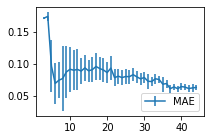

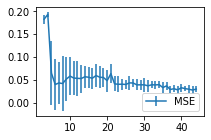

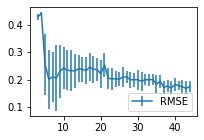

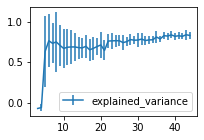

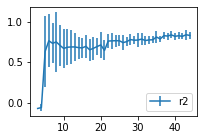

In [60]:
import numpy as np
import matplotlib.pyplot as plt
    

    

scorings = ['MAE','MSE','RMSE','explained_variance','r2']
total_number_of_features = X.shape[1]
# minimum_features_constraint = 3

for scoring in scorings:    
    x = []
    ymax = []
    ymin = []
    y = []
    yerr = []

    for i in range(45):
        x.append(i)
        y.append(0)
        ymax.append(-9999)
        ymin.append(9999)
        yerr.append(0)

    for result in results_xgb:
        index = total_number_of_features-result["n"]
        y[index] = result["regression_results"][scoring]


        if result["regression_results"][scoring] > ymax[index]:
            ymax[index] = result["regression_results"][scoring]

        if result["regression_results"][scoring] < ymin[index]:
            ymin[index] = result["regression_results"][scoring]

    for i in range(45):
        yerr[i] = ymax[i] - ymin[i]


    x = x[3:]
    ymax = ymax[3:]
    ymin = ymin[3:]
    y = y[3:]
    yerr = yerr[3:]


    fig = plt.figure()

    w=3
    h=2
    fig.set_size_inches(w, h)

    plt.errorbar(x, y, yerr=yerr, label=scoring)
    plt.legend(loc='lower right')

In [12]:
%%time

# read the csv file created
train = np.genfromtxt(input_dataset_path, delimiter=',',skip_header=1)


X, y = train[:, 1:], train[:, :1]
y = y.ravel()

# Set training and validation sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

CPU times: user 17.8 s, sys: 1.14 s, total: 19 s
Wall time: 18.7 s


In [16]:
%%time
total_number_of_fetures = X.shape[1]
minimum_features_constraint = 3

print("Org shape: "+str(X.shape))
for n in range(total_number_of_features-minimum_features_constraint):
    
    cols_to_drop = list(range(n+1))
    current_X = np.delete(X, cols_to_drop, 1)
    
    print("Total features considered in this run: " +str(total_number_of_fetures-n))
    
    print("-List of features dropped:"+str(cols_to_drop),str(X.shape))
    
    for feature_to_drop in range(current_X.shape[1]):
        current_X_without_feature = np.delete(current_X, [feature_to_drop], 1)
        
        print("---Evaluating without feature: "+str(feature_to_drop),str(current_X_without_feature.shape))
        
        # define a xgboost model
#         X_train, X_test, y_train, y_test = train_test_split(current_X_without_feature, y, test_size=0.30)
    

Org shape: (489317, 44)
Total features considered in this run: 44
-List of features dropped:[0] (489317, 44)
---Evaluating without feature: 0 (489317, 42)
---Evaluating without feature: 1 (489317, 42)
---Evaluating without feature: 2 (489317, 42)
---Evaluating without feature: 3 (489317, 42)
---Evaluating without feature: 4 (489317, 42)
---Evaluating without feature: 5 (489317, 42)
---Evaluating without feature: 6 (489317, 42)
---Evaluating without feature: 7 (489317, 42)
---Evaluating without feature: 8 (489317, 42)
---Evaluating without feature: 9 (489317, 42)
---Evaluating without feature: 10 (489317, 42)
---Evaluating without feature: 11 (489317, 42)
---Evaluating without feature: 12 (489317, 42)
---Evaluating without feature: 13 (489317, 42)
---Evaluating without feature: 14 (489317, 42)
---Evaluating without feature: 15 (489317, 42)
---Evaluating without feature: 16 (489317, 42)
---Evaluating without feature: 17 (489317, 42)
---Evaluating without feature: 18 (489317, 42)
---Evalu

In [113]:
# import pandas as pd
# train = pd.read_csv(input_dataset_path)
# # divide the dataset on coloums btw target and features
# x, y = train.iloc[:, 1:], train.iloc[:, :1]

# # divide the inputs dataset into training, validation and testing dataset
# train_ratio = 0.70


# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1 - train_ratio)

# read the csv file created
train = np.genfromtxt(input_dataset_path, delimiter=',',skip_header=1)

X, y = train[:, 1:], train[:, :1]
y = y.ravel()

# Set training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [118]:
# test xgboost
import xgboost as xgb

# define a xgboost model
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
       
xg_reg = xgb.XGBRegressor(
    min_child_weight=2,
    eta=1,
    colsample_bytree=0.8,
    eval_metric="auc",
    objective='reg:squarederror',
    max_depth=15,
    n_estimators=20
)

# train xgboost model
xg_reg.fit(X_train,y_train)

# test xgboost model
y_pred = xg_reg.predict(X_test)
regression_results(y_test, y_pred)
# {'r2': 1.0, 'MAE': 0.0, 'MSE': 0.0, 'RMSE': 0.0, 'explained_variance': 1.0}

{'r2': 0.8262,
 'MAE': 0.0607,
 'MSE': 0.0295,
 'RMSE': 0.1717,
 'explained_variance': 0.8262}

In [97]:
# {'r2': 1.0, 'MAE': 0.0, 'MSE': 0.0, 'RMSE': 0.0, 'explained_variance': 1.0}
regression_results(y_test, y_pred)

{'r2': 0.3958,
 'MAE': 0.2054,
 'MSE': 0.1035,
 'RMSE': 0.3218,
 'explained_variance': 0.4762}

In [95]:
from pprint import pprint
pprint(y_test)
pprint(y_pred)

array([0.838348, 0.011885, 0.156596, ..., 0.59038 , 0.638858, 0.014252])
array([0.41549963, 0.23314947, 0.28134957, ..., 0.35507753, 0.5110612 ,
       0.31161803], dtype=float32)


In [27]:
for n in range(X.shape[1]):
    cols_to_drop = range(n)
    current_X = np.delete(a, [0, 3], 1)
    for i in range(X.shape[1]-n):
        #skip ith feature and train a model
        print(n,i)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
5 2
5 3
5 4
6 0
6 1
6 2
6 3
7 0
7 1
7 2
8 0
8 1
9 0


In [ ]:

results = {}
for i in range(train.shape[1]-1):
    subtrain = train
    subtrain = np.delete(subtrain, i, axis=1)[0]
    X, y = train[:, 1:], train[:, :1]
    y = y.ravel()

    # Set training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    dtrain = xgb.DMatrix(X_train, label=y_train)

    num_round = 10
    bst = xgb.train(param, dtrain, num_round)

    dtest = xgb.DMatrix(X_test)
    y_pred = bst.predict(dtest)
    results[i] = regression_results(y_test, y_pred)

In [ ]:
results

In [ ]:
['/scratch/ge3/sg4953/3dem_mag1_fin.level_002_cropped.tif',
 '/scratch/ge3/sg4953/HYDROXYL-1-PC1_clay.level_002_cropped.tif',
 '/scratch/ge3/sg4953/Thorium_2016_cropped.tif',
 '/scratch/ge3/sg4953/Rad2016Th_K_cropped.tif',
 '/scratch/ge3/sg4953/water-85m_cropped.tif',
 '/scratch/ge3/sg4953/Potassium_2016_cropped.tif',
 '/scratch/ge3/sg4953/be-30y-85m-avg_BLUE+SWIR2.level_002_cropped.tif',
 '/scratch/ge3/sg4953/3dem_mag2.level_002_cropped.tif',
 '/scratch/ge3/sg4953/be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata.level_002_cropped.tif',
 '/scratch/ge3/sg4953/saga_wetSM_85_resampled_cropped.tif',
 '/scratch/ge3/sg4953/dem_fill.level_002_cropped.tif']

In [ ]:
# headernp[:, 1:]

with open(str(root)+'/input_dataset.csv', "r") as f:
    reader = csv.reader(f)
    header = next(reader)

header = header[1:]
pprint(header)

In [ ]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [ ]:
r2 = []
MAE = []
MSE = []
RMSE = []
explained_variance = []

In [ ]:
results.items()

In [ ]:
r2 = []
MAE = []
MSE = []
RMSE = []
explained_variance = []
plt.xticks(rotation=90)
for point in results:

    r2.append((header[point], results[point]["r2"]))
    MAE.append((header[point], results[point]["MAE"]))
    MSE.append((header[point], results[point]["MSE"]))
    RMSE.append((header[point], results[point]["RMSE"]))
    explained_variance.append(
        (header[point], results[point]["explained_variance"]))

In [ ]:
plt.xticks(rotation=90)
plt.scatter(*zip(*r2))
plt.show()

In [ ]:
plt.xticks(rotation=90)
plt.scatter(*zip(*MAE))
plt.show()

In [ ]:
plt.xticks(rotation=90)
plt.scatter(*zip(*RMSE))
plt.show()

In [ ]:
plt.xticks(rotation=90)
plt.scatter(*zip(*explained_variance))
plt.show()

## Plotting

In [ ]:
xgb.plot_importance(bst)

In [ ]:
xgb.to_graphviz(bst, num_trees=2)

## Shutdown Cluster

In [37]:
client = distributed.client._get_global_client()
client

In [38]:
client.shutdown()


AttributeError: 'NoneType' object has no attribute 'shutdown'